# Project：资金流入流出预测

1. 网址：https://tianchi.aliyun.com/competition/entrance/231573/information
2. 数据集一共包括4张表：用户基本信息数据、用户申购赎回数据、收益率表和银行间拆借利率表
3. 2.8万用户，284万行为数据，294天拆解利率，427天收益率
4. 2013-07-01到2014-08-31，预测2014年9月的申购和赎回

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 数据加载

In [230]:
# 用户信息表
df_user_profile_table = pd.read_csv('./user_profile_table.csv')
df_user_profile_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28041 entries, 0 to 28040
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        28041 non-null  int64 
 1   sex            28041 non-null  int64 
 2   city           28041 non-null  int64 
 3   constellation  28041 non-null  object
dtypes: int64(3), object(1)
memory usage: 876.4+ KB


In [4]:
df_user_profile_table.head()

,user_id,sex,city,constellation
0,2,1,6411949,狮子座
1,12,1,6412149,摩羯座
2,22,1,6411949,双子座
3,23,1,6411949,双鱼座
4,25,1,6481949,双鱼座


In [5]:
# 用户申购赎回数据表
df_user_balance_table = pd.read_csv('./user_balance_table.csv')
df_user_balance_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840421 entries, 0 to 2840420
Data columns (total 18 columns):
 #   Column               Dtype  
---  ------               -----  
 0   user_id              int64  
 1   report_date          int64  
 2   tBalance             int64  
 3   yBalance             int64  
 4   total_purchase_amt   int64  
 5   direct_purchase_amt  int64  
 6   purchase_bal_amt     int64  
 7   purchase_bank_amt    int64  
 8   total_redeem_amt     int64  
 9   consume_amt          int64  
 10  transfer_amt         int64  
 11  tftobal_amt          int64  
 12  tftocard_amt         int64  
 13  share_amt            int64  
 14  category1            float64
 15  category2            float64
 16  category3            float64
 17  category4            float64
dtypes: float64(4), int64(14)
memory usage: 390.1 MB


In [6]:
df_user_balance_table.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,20140811,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,20140814,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,20140817,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [7]:
# 收益表
df_mfd_day_share_interest = pd.read_csv('./mfd_day_share_interest.csv')
df_mfd_day_share_interest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mfd_date          427 non-null    int64  
 1   mfd_daily_yield   427 non-null    float64
 2   mfd_7daily_yield  427 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 10.1 KB


In [8]:
df_mfd_day_share_interest.head()

,mfd_date,mfd_daily_yield,mfd_7daily_yield
0,20130701,1.5787,6.307
1,20130702,1.5461,6.174
2,20130703,1.4670,6.034
3,20130704,1.4223,5.903
4,20130705,1.3845,5.739


In [9]:
# 同业拆放利率表
df_mfd_bank_shibor = pd.read_csv('./mfd_bank_shibor.csv')
df_mfd_bank_shibor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mfd_date      294 non-null    int64  
 1   Interest_O_N  294 non-null    float64
 2   Interest_1_W  294 non-null    float64
 3   Interest_2_W  294 non-null    float64
 4   Interest_1_M  294 non-null    float64
 5   Interest_3_M  294 non-null    float64
 6   Interest_6_M  294 non-null    float64
 7   Interest_9_M  294 non-null    float64
 8   Interest_1_Y  294 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 20.8 KB


In [10]:
df_mfd_bank_shibor.head()

,mfd_date,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,Interest_6_M,Interest_9_M,Interest_1_Y
0,20130701,4.456,5.423,6.040,6.8800,5.295,4.2390,4.2820,4.4125
1,20130702,3.786,4.750,5.074,5.8000,5.211,4.2344,4.2808,4.4070
2,20130703,3.400,4.242,4.658,5.2000,5.148,4.2300,4.2796,4.4022
3,20130704,3.348,3.938,4.464,5.1020,5.029,4.2287,4.2776,4.4000
4,20130705,3.380,3.816,4.295,4.7885,4.939,4.2273,4.2749,4.4000


In [11]:
# 结果提交表
df_comp_predict_table = pd.read_csv('./comp_predict_table.csv', header=None)
df_comp_predict_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       3 non-null      int64
 1   1       3 non-null      int64
 2   2       3 non-null      int64
dtypes: int64(3)
memory usage: 200.0 bytes


In [12]:
df_comp_predict_table.head()

,0,1,2
0,20140901,40000000,30000000
1,20140902,40000000,30000000
2,20140903,40000000,30000000


## 数据探索

In [13]:
# 日期转换
df_user_balance_table.index = pd.to_datetime(df_user_balance_table['report_date'], format='%Y%m%d', )
df_mfd_day_share_interest['mfd_date'] = pd.to_datetime(df_mfd_day_share_interest['mfd_date'], format='%Y%m%d')
df_mfd_bank_shibor['mfd_date'] = pd.to_datetime(df_mfd_bank_shibor['mfd_date'], format='%Y%m%d')

In [14]:
# 缺失值
df_user_balance_table.isnull().sum()[df_user_balance_table.isnull().sum() != 0]

category1    2666682
category2    2666682
category3    2666682
category4    2666682
dtype: int64

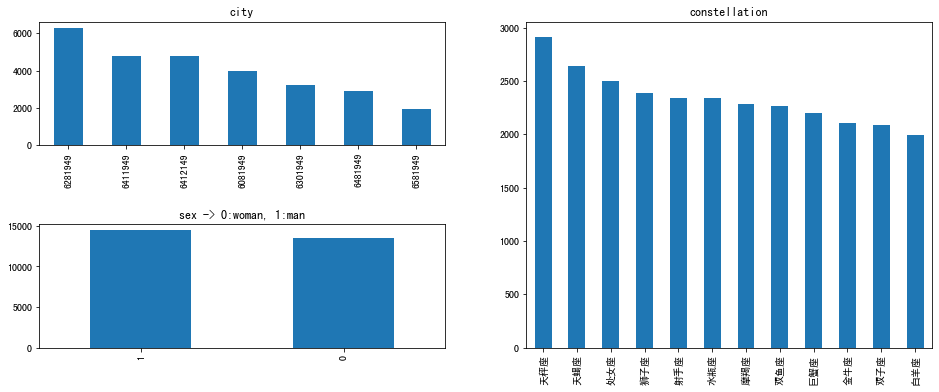

In [15]:
# 用户属性分布
plt.figure(figsize=(16, 6))

plt.subplot2grid((5,2), (0,0), rowspan=2)
df_user_profile_table['city'].value_counts().plot(kind='bar', title='city')

plt.subplot2grid((5,2), (3,0), rowspan=2)
df_user_profile_table['sex'].value_counts().plot(kind='bar', title='sex -> 0:woman, 1:man')

plt.subplot2grid((5,2), (0,1), rowspan=5)
df_user_profile_table['constellation'].value_counts().plot(kind='bar', title='constellation')

plt.show()

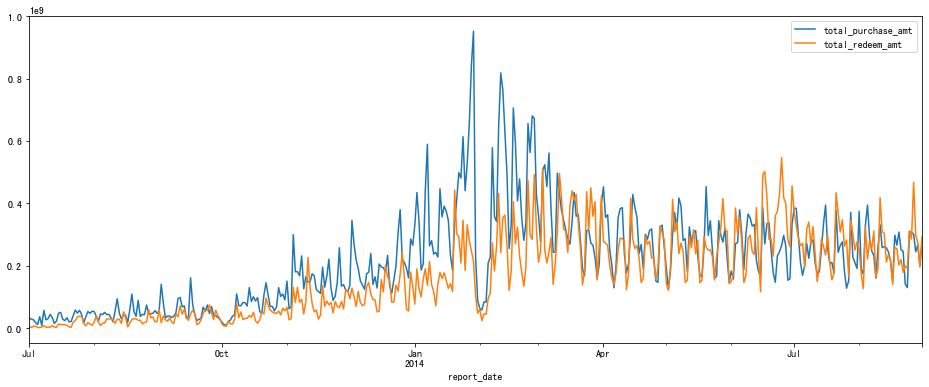

In [16]:
# 申购与赎回走势
df_user_balance_table.resample('D').sum()[['total_purchase_amt', 'total_redeem_amt']].plot(figsize=(16, 6))
plt.show()

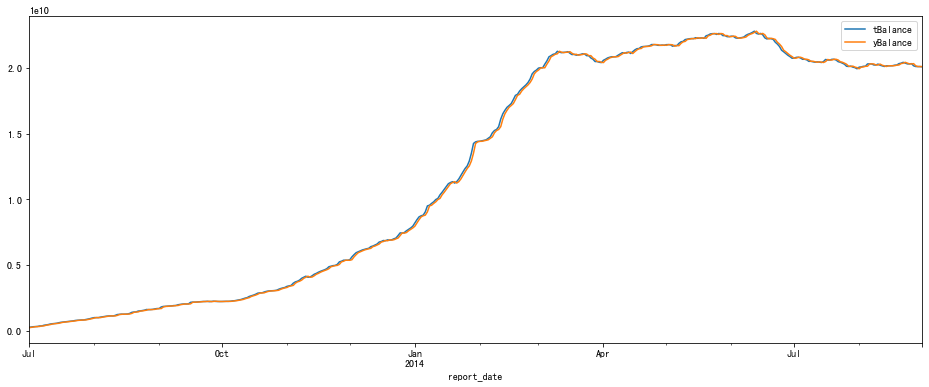

In [17]:
# 今日昨日余额走势
df_user_balance_table.resample('D').sum()[['tBalance', 'yBalance']].plot(figsize=(16, 6))
plt.show()

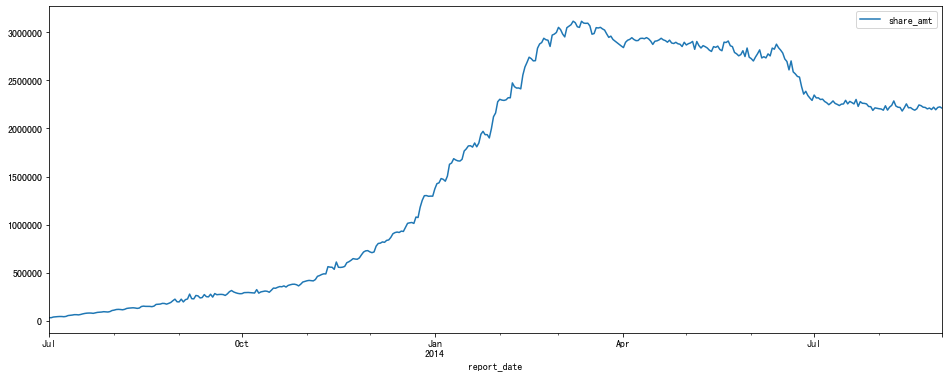

In [18]:
# 今日收益
df_user_balance_table.resample('D').sum()[['share_amt']].plot(figsize=(16, 6))
plt.show()

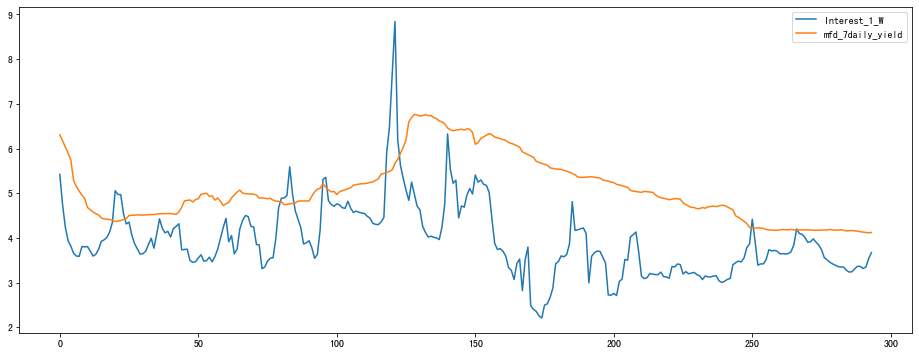

In [19]:
# 7天收益率余额宝与银行
pd.merge(df_mfd_day_share_interest, df_mfd_bank_shibor, on='mfd_date')[['Interest_1_W' ,'mfd_7daily_yield']].plot(figsize=(16, 6))
plt.show()

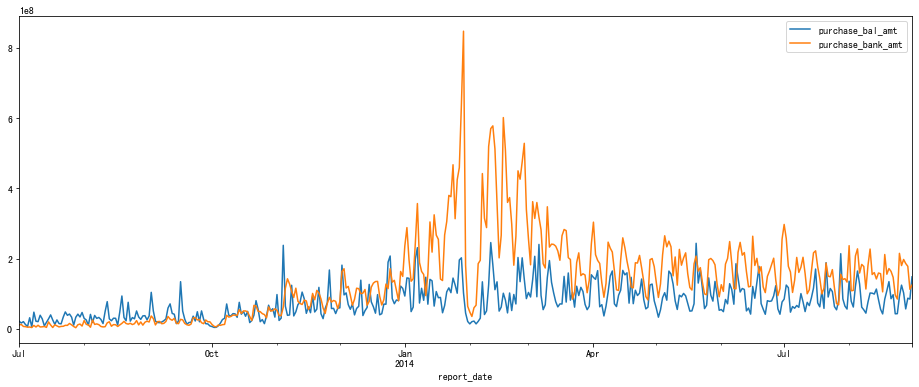

In [20]:
# 支付宝余额宝购买量与银行卡购买量
df_user_balance_table.resample('D').sum()[['purchase_bal_amt', 'purchase_bank_amt']].plot(figsize=(16, 6))
plt.show()

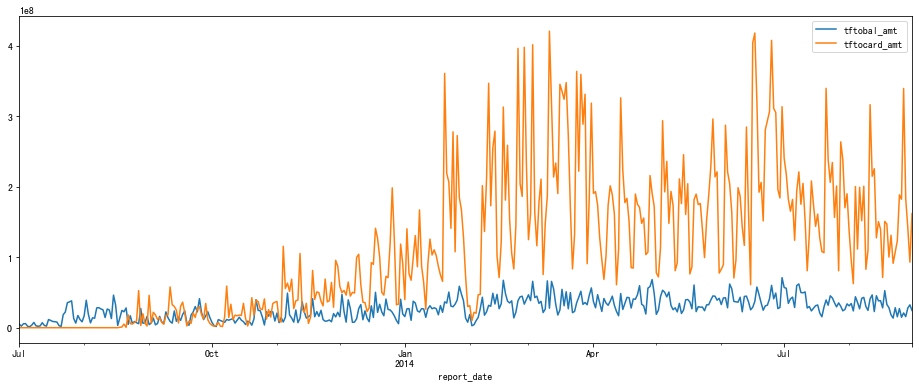

In [21]:
# 转出支付宝与银行卡
df_user_balance_table.resample('D').sum()[['tftobal_amt', 'tftocard_amt']].plot(figsize=(16, 6))
plt.show()

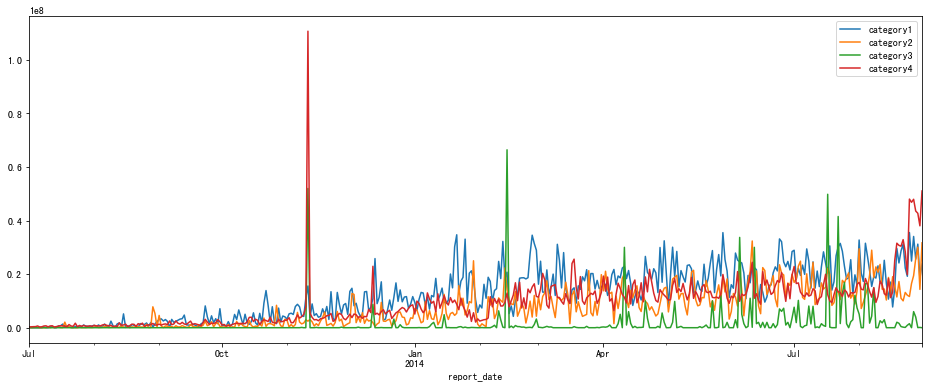

In [22]:
# 消费类目统计
df_user_balance_table.resample('D').sum()[['category1', 'category2', 'category3', 'category4']].plot(figsize=(16, 6))
plt.show()

## 基于时序模型预测

1. prophet
2. ARIMA
3. statsmodels

### Prophet
Finall Score: 75.8042

In [1]:
from fbprophet import Prophet

In [56]:
# 数据提取
df_prophet = df_user_balance_table[['total_purchase_amt', 'total_redeem_amt']].resample('D').sum()
df_prophet['ds'] = df_prophet.index
df_prophet = df_prophet[df_prophet['ds'] >= '2014-04-01']
df_purchase = df_prophet[['ds', 'total_purchase_amt']].rename(columns={'total_purchase_amt': 'y'})
df_redeem = df_prophet[['ds', 'total_redeem_amt']].rename(columns={'total_redeem_amt': 'y'})

In [71]:
# 申购模型预测
prophet_purchase = Prophet(yearly_seasonality=True, weekly_seasonality=True)
prophet_purchase.fit(df_purchase)
purchase_future = prophet_purchase.make_future_dataframe(periods=30)
forecast_purchase = prophet_purchase.predict(purchase_future)

# 赎回模型预测
prophet_redeem = Prophet(yearly_seasonality=True, weekly_seasonality=True)
prophet_redeem.fit(df_redeem)
redeem_future = prophet_redeem.make_future_dataframe(periods=30)
forecast_redeem = prophet_redeem.predict(redeem_future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


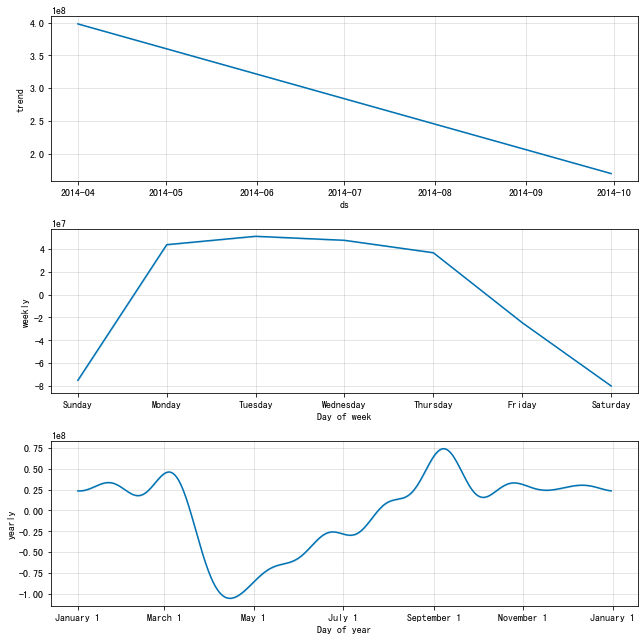

In [72]:
# 周期分析
prophet.plot_components(forecast_purchase)
plt.show()

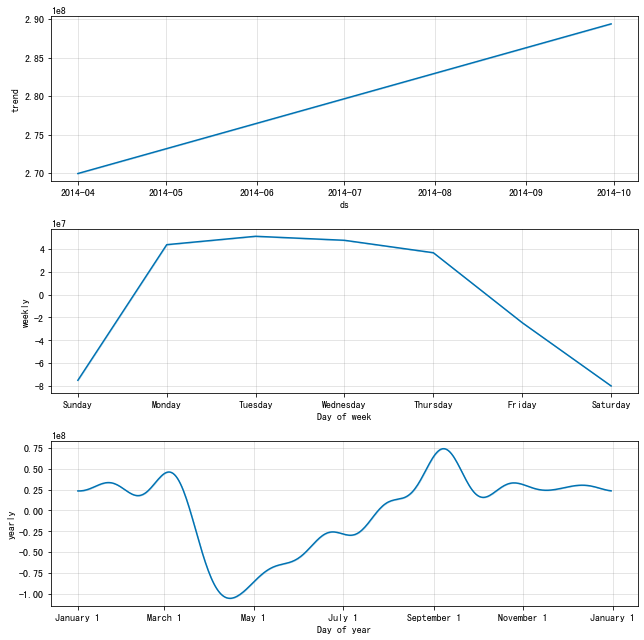

In [73]:
prophet.plot_components(forecast_redeem)
plt.show()

In [103]:
# 预测结果
prophet_result = pd.merge(forecast_purchase[['ds', 'yhat']], forecast_redeem[['ds', 'yhat']], on='ds')
prophet_result = prophet_result.iloc[-30:]
prophet_result['ds'] = prophet_result['ds'].apply(lambda x: '{}{:02d}{:02d}'.format(x.year, x.month, x.day))
prophet_result.to_csv('./predict_prophet.csv', header=None, index=None)

### ARIMA

finall score：88.9272

In [249]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from itertools import product

In [250]:
# 数据提取
df_arima = df_user_balance_table[['total_purchase_amt', 'total_redeem_amt']].resample('D').sum()
df_arima = df_arima[df_arima.index >= '2014-04-01']
arima_purchase_data = df_arima['total_purchase_amt']
arima_redeem_data = df_arima['total_redeem_amt']

In [251]:
# 平稳性监测(1阶差分)
t_purchase = adfuller(arima_purchase_data)
print('无差分是否平稳：', t_purchase[0] < t_purchase[4]['1%'])

t_redeem = adfuller(arima_redeem_data)
print('无差分是否平稳：', t_purchase[0] < t_purchase[4]['1%'])

t_purchase = adfuller(arima_purchase_data.diff().values[1:])
print('1阶差分是否平稳：', t_purchase[0] < t_purchase[4]['1%'])

t_redeem = adfuller(arima_redeem_data.diff().values[1:])
print('1阶差分是否平稳：', t_purchase[0] < t_purchase[4]['1%'])

无差分是否平稳： False
无差分是否平稳： False
1阶差分是否平稳： True
1阶差分是否平稳： True


In [254]:
# 申购预测
arima_purchase = ARIMA(arima_purchase_data, (4, 1, 6)).fit()
arima_purchase_predict = arima_purchase.predict('2014-09-01', '2014-09-30', typ='levels')

# 赎回预测
arima_redeem = ARIMA(arima_redeem_data, (4, 1, 6)).fit()
arima_redeem_predict = arima_redeem.predict('2014-09-01', '2014-09-30', typ='levels')

In [255]:
# 预测结果
arima_result = pd.DataFrame([x+20140901 for x in range(30)])
arima_result['1'] = arima_purchase_predict.values
arima_result['2'] = arima_redeem_predict.values
arima_result.to_csv('./predict_arima.csv', header=None, index=None)

## 基于周期因子预测

finall_score：128.6701

In [394]:
def get_weekday_factor(df, date_begin, date_end, target_col):
    
    # 按日重采样
    df = df[(df.index <= date_end)&(df.index >= date_begin)].resample('D').sum()[[target_col]]
    
    # 计算周期因子
    df['date'] = df.index
    df['weekday'] = df['date'].dt.weekday
    factor = df.groupby('weekday').mean().reset_index()
    factor[target_col] = factor[target_col] / df[target_col].mean()
    factor = factor.rename(columns={target_col: 'weekday_factor'})
    return factor

def get_day_base(df, date_begin, date_end, target_col):
    
    # 按日重采样
    df = df[(df.index <= date_end)&(df.index >= date_begin)].resample('D').sum()[[target_col]]
    
    # 计算每日均值
    df['date'] = df.index
    df['day'] = df['date'].dt.day
    day_mean = df.groupby('day', as_index=False).mean()
    day_mean.rename(columns={target_col: 'day_mean'}, inplace=True)
    
    # 计算日期因子
    df['weekday'] = df['date'].dt.weekday
    temp = df[['date', 'weekday', 'day']].groupby(['day', 'weekday'], as_index=False).count()
    week_factor = get_weekday_factor(df, date_begin, date_end, target_col)
    
    temp = pd.merge(temp, week_factor, on='weekday')
    temp['result'] = temp['date'] * temp['weekday_factor'] / df['date'].dt.month.nunique()
    temp = temp.drop(['weekday', 'date', 'weekday_factor'], axis=1).groupby('day', as_index=False).sum()
    temp = pd.merge(temp, day_mean, on='day')
    temp['result'] = temp['day_mean'] / temp['result']
    
    return temp[['day', 'result']]

In [395]:
# 获取申购base和factor
purchase_day_base = get_day_base(df_user_balance_table, '2014-01-01', '2014-08-31', 'total_purchase_amt')
purchase_weedday_factor = get_weekday_factor(df_user_balance_table, '2014-01-01', '2014-08-31', 'total_purchase_amt')

# 获取赎回base和factor
redeem_day_base = get_day_base(df_user_balance_table, '2014-01-01', '2014-08-31', 'total_redeem_amt')
redeem_weedday_factor = get_weekday_factor(df_user_balance_table, '2014-01-01', '2014-08-31', 'total_redeem_amt')

In [396]:
# 计算结果
purchase_day_base = purchase_day_base.iloc[:-1]
purchase_day_base['month_day'] = purchase_day_base['day'].apply(lambda x: '2014-09-{:02d}'.format(x))
purchase_day_base['day'] = pd.to_datetime(purchase_day_base['month_day'])
purchase_day_base['weekday'] = purchase_day_base['day'].dt.weekday
purchase_factor_predict = pd.merge(purchase_day_base, purchase_weedday_factor, on='weekday')
purchase_factor_predict.sort_values('day', inplace=True)
purchase_factor_predict['predict'] = purchase_factor_predict['result'] * purchase_factor_predict['weekday_factor']

redeem_day_base = redeem_day_base.iloc[:-1]
redeem_day_base['month_day'] = redeem_day_base['day'].apply(lambda x: '2014-09-{:02d}'.format(x))
redeem_day_base['day'] = pd.to_datetime(redeem_day_base['month_day'])
redeem_day_base['weekday'] = redeem_day_base['day'].dt.weekday
redeem_factor_predict = pd.merge(redeem_day_base, redeem_weedday_factor, on='weekday')
redeem_factor_predict.sort_values('day', inplace=True)
redeem_factor_predict['predict'] = redeem_factor_predict['result'] * redeem_factor_predict['weekday_factor']

predict_factor = pd.merge(purchase_factor_predict[['day', 'predict']], redeem_factor_predict[['day', 'predict']], on='day')
predict_factor['day'] = [20140901+x for x in range(30)]

predict_factor.to_csv('./predict_factor.csv', header=None, index=None)